In [127]:
import turicreate as tc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')


## Read in the data file downloaded from 'https://missingmigrants.iom.int/about'

In [128]:
sf = tc.SFrame.read_csv('MissingMigrants-Global-2021-02-05T11-09-55.csv')
sf.print_rows(3)

Finished parsing file /Users/prashantmudgal/Documents/Quantplex Labs/Migrants/MissingMigrants-Global-2021-02-05T11-09-55.csv

Parsing completed. Parsed 100 lines in 0.058996 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str,str,int,str,str,str,int,str,str,str,str,str,str,str,str,str,str,str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Users/prashantmudgal/Documents/Quantplex Labs/Migrants/MissingMigrants-Global-2021-02-05T11-09-55.csv

Parsing completed. Parsed 8133 lines in 0.041279 secs.

+--------+------------------+-------------------+---------------+----------------+
| Web ID |      Region      |   Reported Date   | Reported Year | Reported Month |
+--------+------------------+-------------------+---------------+----------------+
| 54688  | Central America  | February 03, 2021 |      2021     |      Feb       |
| 54687  | US-Mexico Border | February 02, 2021 |      2021     |      Feb       |
| 54686  | Central America  | February 01, 2021 |      2021     |      Feb       |
+--------+------------------+-------------------+---------------+----------------+
+-------------+-------------------------------+------------------------+---------------------+
| Number Dead | Minimum Estimated Number o... | Total Dead and Missing | Number of Survivors |
+-------------+-------------------------------+------------------------+---------------------+
|      1      |                               |           1            |          24         |
|      2      |                        

In [129]:
sf.shape

(8133, 20)

In [130]:
tc.visualization.set_target(target='browser')
sf.explore()

In [131]:
dict = {}
for col in sf.column_names():
     dict.update({col : (sf[sf[col] == ''].shape[0]/sf.shape[0]) * 100})
    
res = []
for val in dict.keys():
    res.append(dict[val])

In [132]:
sf_missing = tc.SFrame({'col': dict.keys(), 'perc': res})
sf_missing.print_rows(20)

+-------------------------------+---------------------+
|              col              |         perc        |
+-------------------------------+---------------------+
|             Web ID            |         0.0         |
|             Region            |         0.0         |
|         Reported Date         |         0.0         |
|         Reported Year         |         0.0         |
|         Reported Month        |         0.0         |
|          Number Dead          |  3.7993360383622274 |
| Minimum Estimated Number o... |  90.93815320300013  |
|     Total Dead and Missing    |         0.0         |
|      Number of Survivors      |  85.42973072666913  |
|       Number of Females       |  78.99913930898808  |
|        Number of Males        |  42.530431575064554 |
|       Number of Children      |  86.26583056682651  |
|         Cause of Death        |  0.8729865978113858 |
|      Location Description     | 0.12295585884667404 |
|       Information Source      | 0.024591171769

### There are many columns with a lot of missing values, maybe we need to drop such columns that have 90 or 70 percent missing rate

In [133]:
sf_deaths = sf.groupby(key_column_names= 'Cause of Death', operations = tc.aggregate.SUM('Total Dead and Missing')).sort('Sum of Total Dead and Missing', ascending=False)

In [134]:
sf_deaths_topK = sf_deaths[0:20]
sf_deaths_topK.print_rows(3)

+-------------------------------+-------------------------------+
|         Cause of Death        | Sum of Total Dead and Missing |
+-------------------------------+-------------------------------+
|            Drowning           |             17496             |
|       Presumed drowning       |              5857             |
| Sickness and lack of acces... |              2156             |
+-------------------------------+-------------------------------+
[20 rows x 2 columns]



## Most prominent cause of deaths

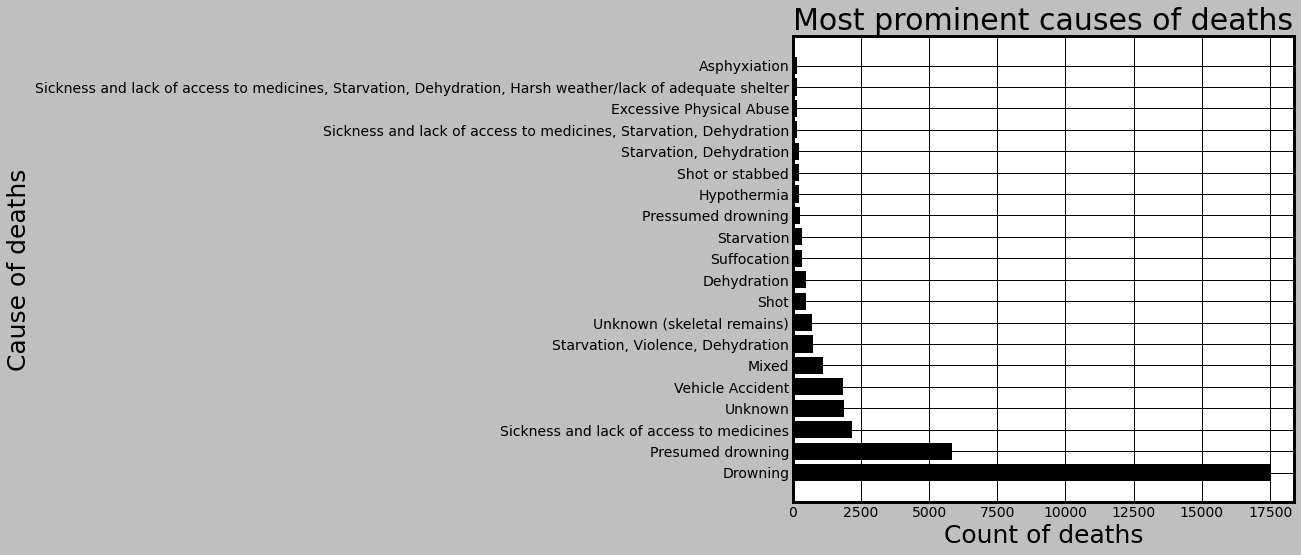

In [136]:
plt.figure(figsize=(8, 8))
plt.style.use('grayscale')
plt.barh(sf_deaths_topK['Cause of Death'], sf_deaths_topK['Sum of Total Dead and Missing'])
plt.xlabel('Count of deaths', size = 25); plt.ylabel('Cause of deaths', size = 25); 
plt.title('Most prominent causes of deaths', size = 30);
plt.show()

In [137]:
## Checking with altair(repeat of above chart)

In [180]:
source = sf_deaths_topK.to_dataframe()
source.rename(columns= {'Cause of Death': 'Death_Cause'}, inplace=True)


In [187]:
import altair as alt

chart = alt.Chart(source).mark_bar(color='#808080').encode(
    x=alt.X('Sum of Total Dead and Missing:Q',axis=alt.Axis(title='Count of deaths')),
    y=alt.Y("Death_Cause:O", sort= '-x', axis=alt.Axis(title='Cause of deaths')),
    color=alt.condition(
        alt.datum.Death_Cause == "Drowning",  # 
        alt.value('orange'),     # which sets the bar orange.
        alt.value('grey')   # And if it's not true it sets the bar steelblue.
    )
).properties(height=400, width = 600, title='Most prominent causes of deaths')

chart.configure_title(
    fontSize=22,
    font='Helvetica',
    anchor='middle',
    color='#808080'
)

alt.Chart(...)

## Deaths in the years

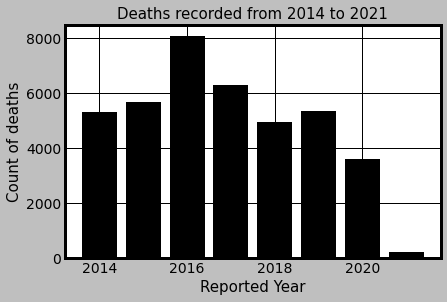

In [188]:
tmp = sf.groupby('Reported Year', tc.aggregate.SUM('Total Dead and Missing')).sort('Reported Year', ascending = True)
plt.figure(figsize=(6, 4))
plt.style.use('grayscale')
plt.bar(tmp['Reported Year'], tmp['Sum of Total Dead and Missing'])
plt.xlabel('Reported Year', size = 15); plt.ylabel('Count of deaths', size = 15); 
plt.title('Deaths recorded from 2014 to 2021', size = 15);
plt.show()


In [193]:
source = tmp.to_dataframe()
chart = alt.Chart(source).mark_bar(color='#5a5a5a').encode(
    x=alt.X('Reported Year:O',axis=alt.Axis(title='Reported Year')),
    y=alt.Y("Sum of Total Dead and Missing:Q", axis=alt.Axis(title='Count of Deaths'))
).properties(height=300, width = 600, title="Deaths recorded from 2014 to 2021")


chart.configure_title(
    fontSize=20,
    font='Helvetica',
    anchor='middle',
    color='#5a5a5a'
)

alt.Chart(...)

## UNSD Geography Grouping in which deaths are occurring

In [194]:
geo_group = []
for row in sf['UNSD Geographical Grouping']:
    if row == '':
        geo_group.append('unknown')
    else:
        geo_group.append(row)

sf['UNSD Geographical Grouping'] = geo_group

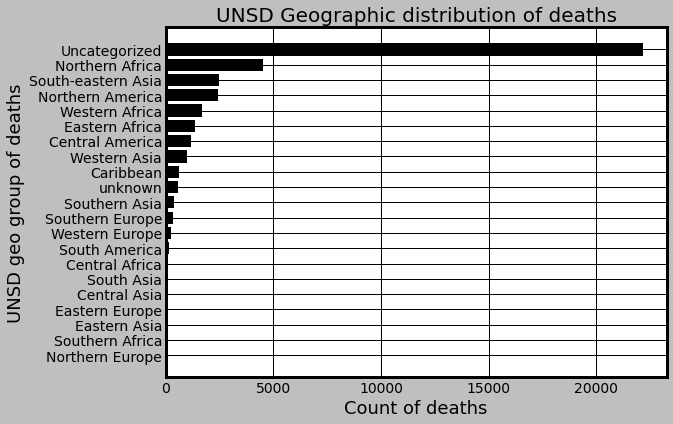

In [195]:
tmp = sf.groupby('UNSD Geographical Grouping', tc.aggregate.SUM('Total Dead and Missing')).sort('Sum of Total Dead and Missing', ascending = True)
plt.figure(figsize=(8, 6))
plt.style.use('grayscale')
plt.barh(tmp['UNSD Geographical Grouping'], tmp['Sum of Total Dead and Missing'])
plt.xlabel('Count of deaths', size = 18); plt.ylabel('UNSD geo group of deaths', size = 18); 
plt.title('UNSD Geographic distribution of deaths', size = 20);
plt.show()

## Number of deaths by Region

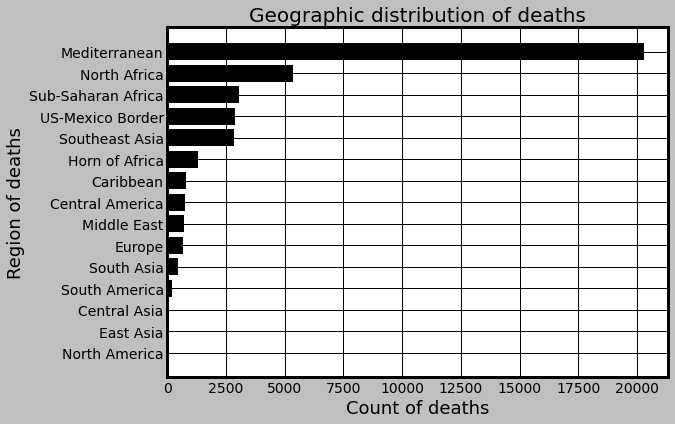

In [220]:
tmp = sf.groupby('Region', tc.aggregate.SUM('Total Dead and Missing')).sort('Sum of Total Dead and Missing', ascending = True)
plt.figure(figsize=(8, 6))
plt.style.use('grayscale')
plt.barh(tmp['Region'], tmp['Sum of Total Dead and Missing'])
plt.xlabel('Count of deaths', size = 18); plt.ylabel('Region of deaths', size = 18); 
plt.title('Geographic distribution of deaths', size = 20);
plt.show()

In [235]:
source = tmp.to_dataframe()

chart = alt.Chart(source).mark_bar(color='#808080').encode(
    x=alt.X('Sum of Total Dead and Missing:Q',axis=alt.Axis(title='Count of deaths')),
    y=alt.Y("Region:O", sort= '-x'),
    color=alt.condition(
        alt.datum.Region ==  "Southeast Asia" or alt.datum.Region == "US-Mexico Border" ,  # 
        alt.value('red'),     # which sets the bar orange.
        alt.value('#808080')   # And if it's not true it sets the bar steelblue.
    )
).properties(height=400, width = 600, title="Geographic distribution of deaths")


chart.configure_title(
    fontSize=22,
    font='Helvetica',
    anchor='middle',
    color='#808080'
)

alt.Chart(...)

## Scale of migration

In [199]:
survivors = []
for row in sf['Number of Survivors']:
    if row == '':
        survivors.append(0)
    else:
        survivors.append(int(row))
    

In [200]:
sf['survivors'] = survivors

In [201]:
sf['total_attempt'] = sf.apply(lambda x : x['survivors'] + x['Total Dead and Missing'])

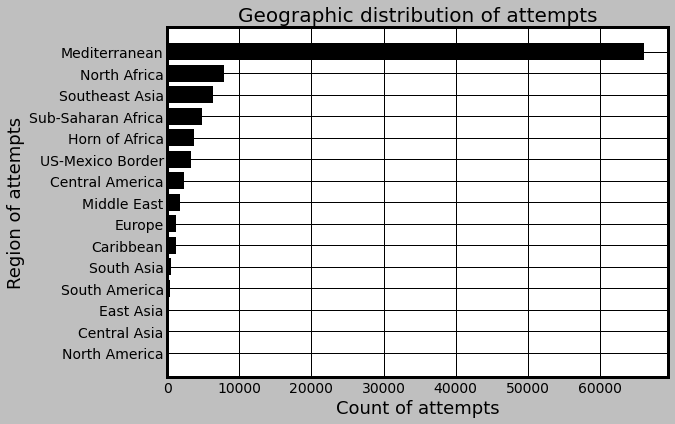

In [202]:
tmp = sf.groupby('Region', tc.aggregate.SUM('total_attempt')).sort('Sum of total_attempt', ascending = True)
plt.figure(figsize=(8, 6))
plt.style.use('grayscale')
plt.barh(tmp['Region'], tmp['Sum of total_attempt'])
plt.xlabel('Count of attempts', size = 18); plt.ylabel('Region of attempts', size = 18); 
plt.title('Geographic distribution of attempts', size = 20);
plt.show()

In [203]:
source = tmp.to_dataframe()

chart = alt.Chart(source).mark_bar(color='#003153').encode(
    x=alt.X('Sum of total_attempt:Q',axis=alt.Axis(title='Count of deaths')),
    y=alt.Y("Region:O", sort= '-x')
).properties(height=400, width = 600, title="Geographic distribution of attempts")


chart.configure_title(
    fontSize=22,
    font='Helvetica',
    anchor='middle',
    color='#003153'
)

alt.Chart(...)

## Cause of death by Region

In [247]:
tmp = sf.groupby(['Region','Cause of Death'], tc.aggregate.SUM('Total Dead and Missing'))
tmp

Cause of Death,Region,Sum of Total Dead andMissing ...
Violence,US-Mexico Border,4
"Dehydration, Exposure",US-Mexico Border,4
Mixed,US-Mexico Border,619
Fall,Europe,2
Crushed in back of truck,Europe,5
Vehicle Accident,US-Mexico Border,68
Fall into a canyon,US-Mexico Border,1
Injuries after fallingfrom border wall ...,US-Mexico Border,1
Rockslide,Europe,2
Presumed hyperthermia,US-Mexico Border,36


In [248]:
region_list = []
for region in tmp['Region'].unique():
    region_list.append(tmp[tmp['Region'] == region].sort('Sum of Total Dead and Missing', ascending = False)[0])
    

In [249]:
cause = []
region_x = []
count = []
label_synthetic = []

for rgn in region_list:
    count.append(rgn['Sum of Total Dead and Missing'])
    region_x.append(rgn['Region'])
    cause.append(rgn['Cause of Death'])
    label_synthetic.append(rgn['Region']+ "<=>" + rgn['Cause of Death'])



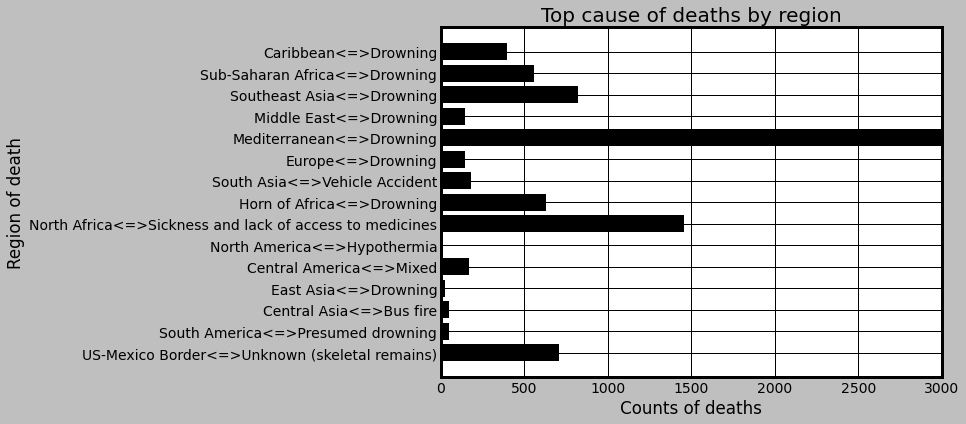

In [250]:
fig, ax = plt.subplots(figsize = (8, 6))
plt.style.use('grayscale')
ax.barh(label_synthetic, count)
ax.set_xlabel('Counts of deaths')
ax.set_ylabel('Region of death')
plt.title('Top cause of deaths by region', size = 20);
plt.xlim(0, 3000)
plt.show()


In [251]:
import pandas as pd
df = pd.DataFrame(list(zip(cause, region_x, count)), 
               columns =['Cause', 'Region', 'Count'])

In [252]:
df


,Cause,Region,Count
0,Unknown (skeletal remains),US-Mexico Border,706
1,Presumed drowning,South America,49
2,Bus fire,Central Asia,52
3,Drowning,East Asia,27
4,Mixed,Central America,168
5,Hypothermia,North America,1
6,Sickness and lack of access to medicines,North Africa,1454
7,Drowning,Horn of Africa,629
8,Vehicle Accident,South Asia,181
9,Drowning,Europe,143


In [293]:
chart = alt.Chart(df).mark_bar(color='#808080').encode(
    x=alt.X('Count:Q',  scale=alt.Scale(domain=[0,3000], clamp = True), axis=alt.Axis(title='Count of deaths')),
    y=alt.Y("Region:O",axis=alt.Axis(title='Region of deaths'))
).properties(height=400, width = 600, title="Top cause of deaths by region")


text = chart.mark_text(
    align='left',
    baseline='middle',
    color= 'steelblue',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text= 'Cause:O'
)

(chart+text).configure_title(
    fontSize=22,
    font='Helvetica',
    anchor='middle',
    color='grey'
)

alt.LayerChart(...)

## Year- month timeline

In [294]:
sf['Reported-Month-Year'] = sf.apply(lambda x : str(x['Reported Month']) + "-" + str(x['Reported Year']))

In [295]:
tmp = sf.groupby(['Reported-Month-Year', 'Reported Year', 'Reported Month'], tc.aggregate.SUM('Total Dead and Missing')).sort(['Reported Month', 'Reported Year'], ascending= True)
tmp

Reported Month,Reported Year,Reported-Month-Year,Sum of Total Dead andMissing ...
Apr,2014,Apr-2014,105
Apr,2015,Apr-2015,574
Apr,2016,Apr-2016,745
Apr,2017,Apr-2017,382
Apr,2018,Apr-2018,339
Apr,2019,Apr-2019,387
Apr,2020,Apr-2020,173
Aug,2014,Aug-2014,788
Aug,2015,Aug-2015,883
Aug,2016,Aug-2016,245


In [296]:
import datetime
tmp['Time-Month-Year'] = tmp.apply(lambda x : datetime.datetime.strptime(x['Reported-Month-Year'], '%b-%Y'))

In [297]:
tmp = tmp.sort('Time-Month-Year', ascending=True)

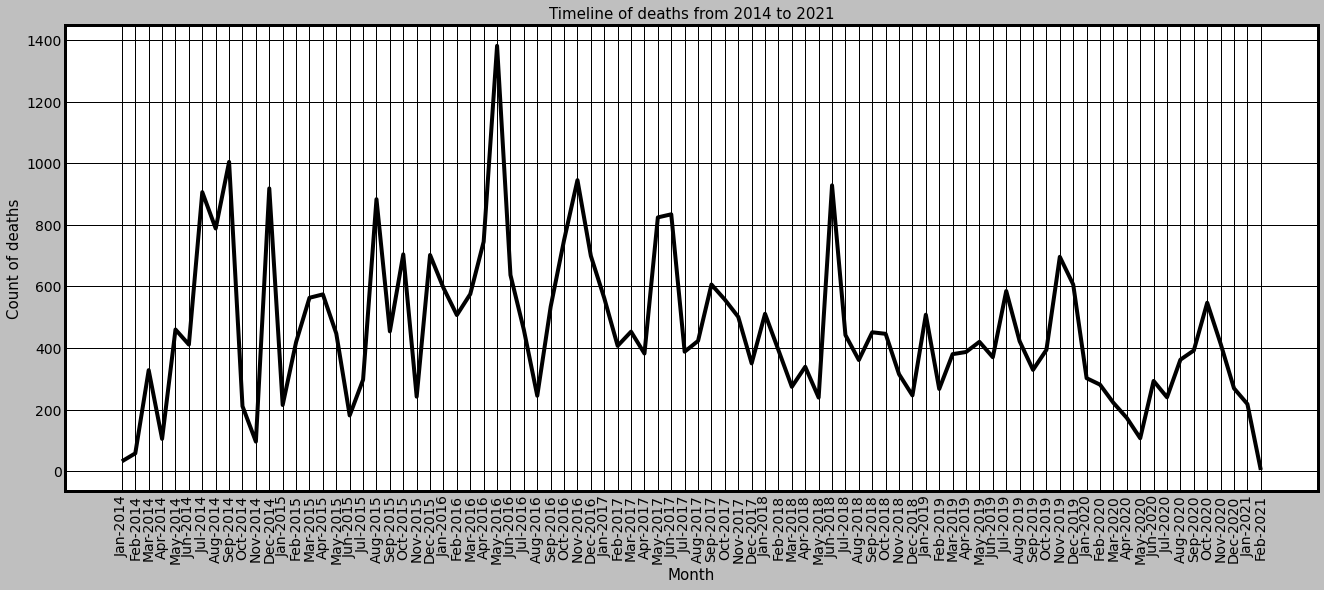

In [298]:
plt.figure(figsize=(20, 8))
plt.style.use('grayscale')
plt.plot(tmp['Reported-Month-Year'], tmp['Sum of Total Dead and Missing'])
plt.xlabel('Month', size = 15); plt.ylabel('Count of deaths', size = 15); 
plt.xticks(rotation=90)
plt.title('Timeline of deaths from 2014 to 2021', size = 15);
plt.show()


In [302]:
source

,Reported Month,Reported Year,Reported-Month-Year,Sum of Total Dead and Missing,Time-Month-Year
0,Jan,2014,Jan-2014,32,2014-01-01
1,Feb,2014,Feb-2014,58,2014-02-01
2,Mar,2014,Mar-2014,328,2014-03-01
3,Apr,2014,Apr-2014,105,2014-04-01
4,May,2014,May-2014,460,2014-05-01
...,...,...,...,...,...
81,Oct,2020,Oct-2020,547,2020-10-01
82,Nov,2020,Nov-2020,414,2020-11-01
83,Dec,2020,Dec-2020,269,2020-12-01
84,Jan,2021,Jan-2021,218,2021-01-01


In [366]:
source = tmp.to_dataframe()

chart = alt.Chart(source).mark_line().encode(
    x=alt.X('Time-Month-Year:O', axis=alt.Axis(title='Month')),
    y=alt.Y("Sum of Total Dead and Missing:Q",axis=alt.Axis(title='Count of deaths')),
    color = alt.Color('Reported Year', scale=alt.Scale(scheme = 'redgrey')),
    strokeDash='Reported Year:O'
).properties(height=400, width = 800, title="Timeline of deaths")



chart

alt.Chart(...)

## There has been a spike in 2016 Summer, I believe it was the time when news was flooded with the migrant crisis in Europe

In [367]:
tmp = sf.groupby('Reported Month', tc.aggregate.SUM('Total Dead and Missing'))
tmp['Time-Month'] = tmp.apply(lambda x : datetime.datetime.strptime(x['Reported Month'], '%b'))
tmp = tmp.sort('Time-Month', ascending= True)

## Summer months are expected to have more deaths as they have more activity

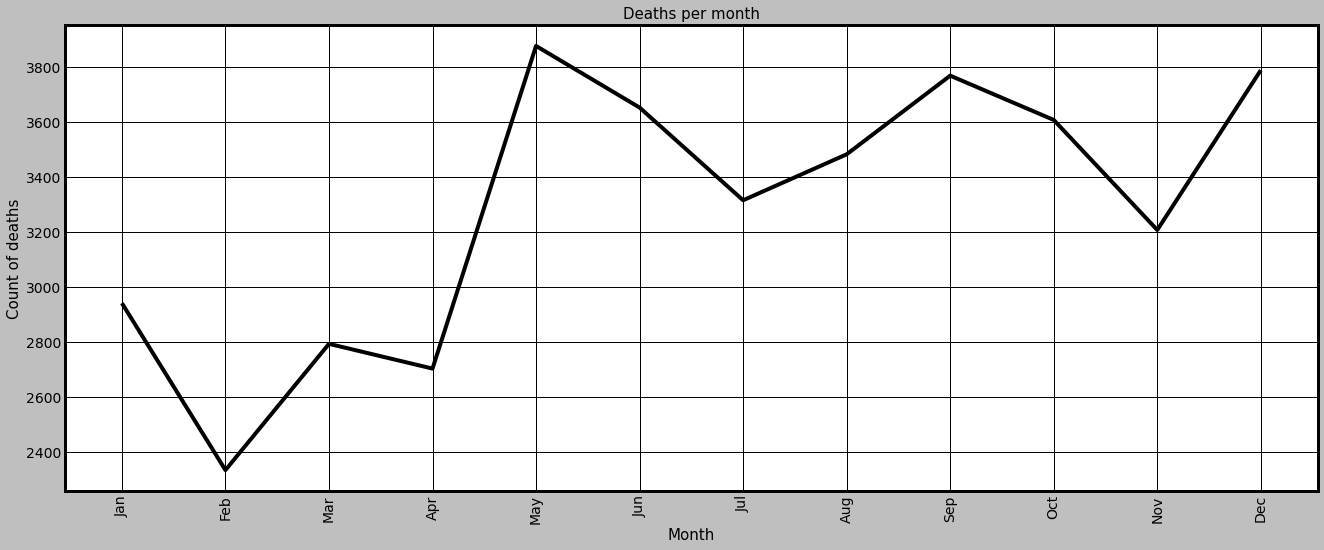

In [368]:
plt.figure(figsize=(20, 8))
plt.style.use('grayscale')
plt.plot(tmp['Reported Month'], tmp['Sum of Total Dead and Missing'])
plt.xlabel('Month', size = 15); plt.ylabel('Count of deaths', size = 15); 
plt.xticks(rotation=90)
plt.title('Deaths per month', size = 15);
plt.show()

## Understanding the survivorship

In [474]:
tmp = sf[sf['Number of Survivors'] != '']
tmp.shape

(1185, 21)

In [500]:
died_or_missing = tmp['Total Dead and Missing'].sum()
died_or_missing

19809

In [493]:
tmp['Number of Survivors'] = tmp.apply(lambda x : int(x['Number of Survivors']))

In [499]:
survivors = tmp['Number of Survivors'].sum()
survivors

60349

In [498]:
percentage_survived = (survivors * 100) / (survivors + died_or_missing)
percentage_survived

75.28755707477731

In [504]:
tmp = sf[(sf['Number of Survivors'] != '') & (sf['Migration Route'] != '')]

In [509]:
tmp['Number of Survivors'] = tmp.apply(lambda x : int(x['Number of Survivors']))

In [511]:
tmp.groupby('Migration Route', tc.aggregate.SUM('Number of Survivors')).sort('Sum of Number of Survivors', ascending = False)

Migration Route,Sum of Number ofSurvivors ...
Central Mediterranean,38367
Western Mediterranean,3898
Eastern Mediterranean,3594
Western Africa / Atlanticroute to the Canary ...,2446
Horn of Africa to Yemen,2056
Central America to US,1158
Western Balkans,290
English Channel to the UK,27
Dominican Republic toPuerto Rico ...,27
Darien Gap,24


## For the available data, Mediterranean route has maximum number of survivors. It could also be the case because the route sees a lot of traffic

In [373]:
sf['lat'] = sf.apply(lambda x : float(x['Location Coordinates'].split(',')[0]))
sf['long'] = sf.apply(lambda x : float(x['Location Coordinates'].split(',')[1]))

In [374]:
lat = sf['lat']
lon = sf['long']


In [375]:
import folium 
from folium import plugins
from folium.plugins import HeatMap

In [376]:
df = sf.to_dataframe()
base_map =  folium.Map(location = [lat.mean(), lon.mean()], zoom_start=3, min_zoom = 2.5, control_scale = True)

In [377]:
HeatMap(data=df[['lat', 'long', 'Total Dead and Missing']].groupby(['lat', 'long']).sum().
        reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)

In [378]:
base_map

## Gender and age of those who lost the lives

In [679]:
sf['Total Dead and Missing'].sum()

39490

In [681]:
def str_to_int(col_name):
    lst = []
    for row in sf[col_name]:
        if row == '':
            lst.append(0)
        else:
            lst.append(int(row))
    return lst   

In [686]:
males = str_to_int('Number of Males')
females = str_to_int('Number of Females')
children = str_to_int('Number of Children')

In [688]:
print("Male deaths documented: ", sum(males))
print("Female deaths documented: ", sum(females))
print("Children deaths documented: ", sum(children))

Male deaths documented:  8342
Female deaths documented:  3047
Children deaths documented:  2319
